In [1]:
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import rocks
rocks.set_log_level("error")
import time as t

from scipy.optimize import curve_fit


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import angular_separation

from astropy.modeling import models, fitting
from scipy import special

from fink_utils.sso import spins as finkus

In [2]:
# G12 line in G1G2 space
def G12_to_G1G2(g12):

    G1_a, G2_a = 0.0, 0.53513350
    G1_b, G2_b = 0.84293649, -0.53513350

    G1 = G1_a + g12 * G1_b
    G2 = G2_a + g12 * G2_b

    return G1, G2

# Simple 1D Gaussian
def gauss(x, m, mu, sigma):
    return m * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Two 1D Gaussians
def double_gauss(x, m1, mu1, sigma1, m2, mu2, sigma2):
    g1 = gauss(x, m1, mu1, sigma1)
    g2 = gauss(x, m2, mu2, sigma2)
    return g1 + g2

# Get ZTF fit

In [3]:
# Local Configuration
bft_file = '/data/ssodnet/ssoBFT-latest.parquet'
data_fink = '/data/fink/tutorials/sso/spins/'
data_fink = './'

# To choose the definition of sets
# gold_silver_choice = 'julien'
gold_silver_choice = 'benoit'

In [4]:
# ZTF filters 1: g, 2: r
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])


In [5]:
data = pd.read_parquet(f'{data_fink}data/sso_bft_50_inf_allsolutions.parquet')

In [6]:
bft = pd.read_parquet(bft_file)

cols = ['sso_number', 'sso_name', 'sso_class',
        'orbital_elements.semi_major_axis.value',
        'orbital_elements.eccentricity.value',
        'orbital_elements.inclination.value',
        'orbital_elements.node_longitude.value',
        'orbital_elements.perihelion_argument.value',
        'orbital_elements.mean_anomaly.value',
        'orbital_elements.mean_motion.value',
        'family.family_number', 'family.family_name',
        'tisserand_parameters.Jupiter.value',
        'albedo.value',
        'absolute_magnitude.value', 
        'diameter.value', 
        'taxonomy.class', 'taxonomy.complex', 'taxonomy.waverange', 'taxonomy.scheme', 'taxonomy.technique',
        'colors.g-r.color.value', 'colors.g-r.color.error.min', 'colors.g-r.color.error.max',
        'colors.g-r.facility', 'colors.g-r.observer', 'colors.g-r.epoch',
        'colors.g-r.delta_time', 'colors.g-r.id_filter_1',
        'colors.g-r.id_filter_2', 'colors.g-r.phot_sys', 'colors.g-r.technique',
        'spins.1.obliquity', 'spins.1.RA0.value', 'spins.1.DEC0.value',
        'spins.1.long.value', 'spins.1.lat.value', 'spins.1.technique',
        'spins.2.obliquity', 'spins.2.RA0.value', 'spins.2.DEC0.value',
        'spins.2.long.value', 'spins.2.lat.value', 'spins.2.technique',
        'spins.3.obliquity', 'spins.3.RA0.value', 'spins.3.DEC0.value',
        'spins.3.long.value', 'spins.3.lat.value', 'spins.3.technique',
        'spins.4.obliquity', 'spins.4.RA0.value', 'spins.4.DEC0.value',
        'spins.4.long.value', 'spins.4.lat.value', 'spins.4.technique'
       ] 

data = data.merge( bft[cols], left_on='name', right_on='sso_name', how='left' )

In [7]:
len(data)

104165

# Compare results

In [8]:
data.columns[:80]

Index(['ssnamenr', 'number', 'name', 'minphase', 'maxphase', 'n_days', 'n_obs',
       'HG_H', 'HG_dH', 'HG_G', 'HG_dG', 'HG_rms', 'HG_chi2red', 'HG1G2_H',
       'HG1G2_dH', 'HG1G2_G1', 'HG1G2_dG1', 'HG1G2_G2', 'HG1G2_dG2',
       'HG1G2_rms', 'HG1G2_chi2red', 'HG1G2sp_H', 'HG1G2sp_dH', 'HG1G2sp_G1',
       'HG1G2sp_dG1', 'HG1G2sp_G2', 'HG1G2sp_dG2', 'HG1G2sp_RA0',
       'HG1G2sp_dRA0', 'HG1G2sp_DEC0', 'HG1G2sp_dDEC0', 'HG1G2sp_R',
       'HG1G2sp_dR', 'HG1G2sp_rms', 'HG1G2sp_chi2red', 'HG1G2hyb_H_g',
       'HG1G2hyb_dH_g', 'HG1G2hyb_G1_g', 'HG1G2hyb_dG1_g', 'HG1G2hyb_G2_g',
       'HG1G2hyb_dG2_g', 'HG1G2hyb_H_r', 'HG1G2hyb_dH_r', 'HG1G2hyb_G1_r',
       'HG1G2hyb_dG1_r', 'HG1G2hyb_G2_r', 'HG1G2hyb_dG2_r', 'HG1G2hyb_RA0',
       'HG1G2hyb_dRA0', 'HG1G2hyb_DEC0', 'HG1G2hyb_dDEC0', 'HG1G2hyb_R',
       'HG1G2hyb_dR', 'HG1G2hyb_rms', 'HG1G2hyb_chi2red', 'HG1G2hyb_n_oppo',
       'HG1G2hyb_status', 'HG1G2hyb_fit', 'sso_number', 'sso_name',
       'sso_class', 'orbital_elements.semi_maj

In [9]:
thres = 1e-3

maskG1G2 = (data.HG1G2_G1>thres)  & (data.HG1G2_G2>thres) & (1-data.HG1G2_G1-data.HG1G2_G2>thres)
maskG1G2sp = (data.HG1G2sp_G1>thres)  & (data.HG1G2sp_G2>thres) & (1-data.HG1G2sp_G1-data.HG1G2sp_G2>thres)
maskG1G2hyb_g = (data.HG1G2hyb_G1_g>thres)  & (data.HG1G2hyb_G2_g>thres) & (1-data.HG1G2hyb_G1_g-data.HG1G2hyb_G2_g>thres)
maskG1G2hyb_r = (data.HG1G2hyb_G1_r>thres)  & (data.HG1G2hyb_G2_r>thres) & (1-data.HG1G2hyb_G1_r-data.HG1G2hyb_G2_r>thres)
maskG1G2hyb = maskG1G2hyb_g * maskG1G2hyb_r

maskPhase = data.minphase<2.5
mask = maskG1G2 * maskG1G2sp * maskG1G2hyb * maskPhase



len(data), len(data[mask]), len(data[maskG1G2]), len(data[maskG1G2sp]), len(data[maskG1G2hyb_g]), len(data[maskG1G2hyb_r]), len(data[maskG1G2hyb])

(104165, 28002, 57063, 66319, 60711, 64665, 47465)

## Difference in absolute magnitude

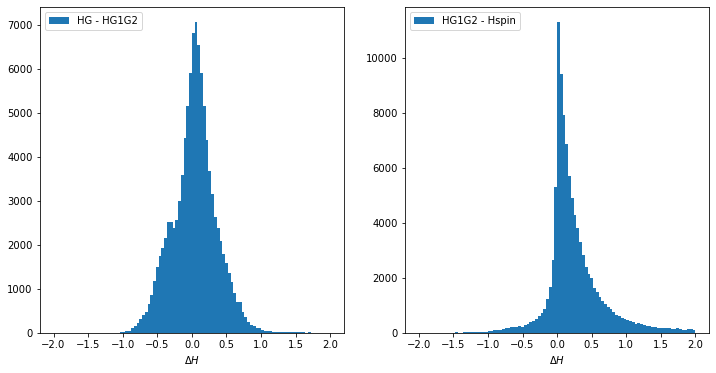

In [10]:
# Different models - single V filter
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

ax[0].hist( data.HG_H - data.HG1G2_H, range=r, bins=b, label='HG - HG1G2' )
ax[1].hist( data.HG1G2_H - data.HG1G2sp_H, range=r, bins=b, label='HG1G2 - Hspin' )

for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    
fig.savefig(f'{data_fink}/gfx_models/deltaH_models.png', facecolor='white')

- HG seems to fail as expected
- HG1G2 vs spin non symmetric: effect of oppositions

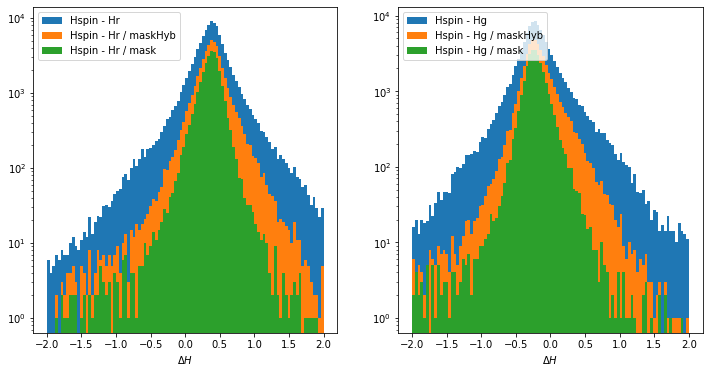

In [11]:
# Different colors
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

ax[0].hist( data.HG1G2sp_H - data.HG1G2hyb_H_r, range=r, bins=b, label='Hspin - Hr' )
ax[0].hist( data.loc[maskG1G2hyb,'HG1G2sp_H'] - data.loc[maskG1G2hyb,'HG1G2hyb_H_r'], range=r, bins=b, label='Hspin - Hr / maskHyb' )
ax[0].hist( data.loc[mask,'HG1G2sp_H'] - data.loc[mask,'HG1G2hyb_H_r'], range=r, bins=b, label='Hspin - Hr / mask' )

ax[1].hist( data.HG1G2sp_H - data.HG1G2hyb_H_g, range=r, bins=b, label='Hspin - Hg' )
ax[1].hist( data.loc[maskG1G2hyb,'HG1G2sp_H'] - data.loc[maskG1G2hyb,'HG1G2hyb_H_g'], range=r, bins=b, label='Hspin - Hg / maskHyb' )
ax[1].hist( data.loc[mask,'HG1G2sp_H'] - data.loc[mask,'HG1G2hyb_H_g'], range=r, bins=b, label='Hspin - Hg / mask' )

for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_yscale('log')
    
fig.savefig(f'{data_fink}/gfx_models/deltaH_spin_hyb_masks.png', facecolor='white')

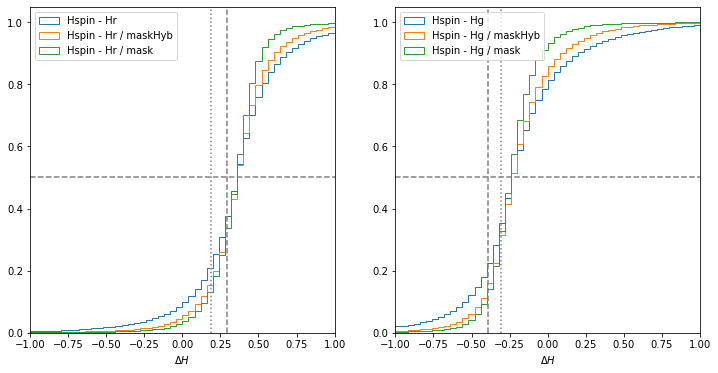

In [12]:
# Different colors
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

ax[0].hist( data.HG1G2sp_H - data.HG1G2hyb_H_r, range=r, bins=b, density=True, cumulative=True, histtype='step', label='Hspin - Hr' )
ax[0].hist( data.loc[maskG1G2hyb,'HG1G2sp_H'] - data.loc[maskG1G2hyb,'HG1G2hyb_H_r'], range=r, bins=b, density=True, cumulative=True, histtype='step', label='Hspin - Hr / maskHyb' )
ax[0].hist( data.loc[mask,'HG1G2sp_H'] - data.loc[mask,'HG1G2hyb_H_r'], range=r, bins=b, density=True, cumulative=True, histtype='step', label='Hspin - Hr / mask' )

ax[1].hist( data.HG1G2sp_H - data.HG1G2hyb_H_g, range=r, bins=b, density=True, cumulative=True, histtype='step', label='Hspin - Hg' )
ax[1].hist( data.loc[maskG1G2hyb,'HG1G2sp_H'] - data.loc[maskG1G2hyb,'HG1G2hyb_H_g'], range=r, bins=b, density=True, cumulative=True, histtype='step', label='Hspin - Hg / maskHyb' )
ax[1].hist( data.loc[mask,'HG1G2sp_H'] - data.loc[mask,'HG1G2hyb_H_g'], range=r, bins=b, density=True, cumulative=True, histtype='step', label='Hspin - Hg / mask' )

for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_xlim( -1, 1 )
    a.axhline(0.5, color='gray', linestyle='--')

ax[0].axvline( sun_color['r'], color='gray', linestyle='dotted')
ax[0].axvline( S_color['r'], color='gray', linestyle='dashed')
ax[1].axvline( sun_color['g'], color='gray', linestyle='dotted')
ax[1].axvline( S_color['g'], color='gray', linestyle='dashed')



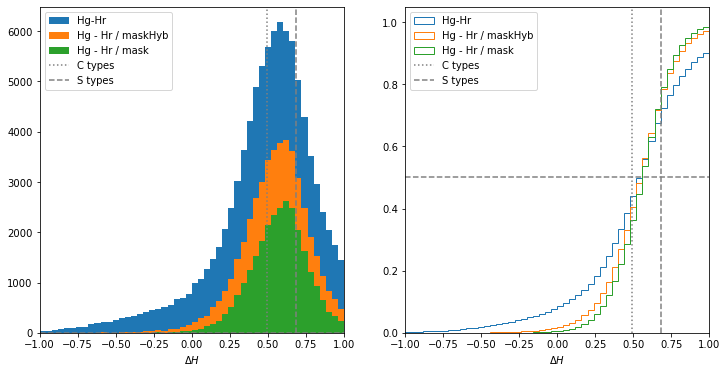

In [13]:
# Hybrid colors vs expectations
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

ax[0].hist( data.HG1G2hyb_H_g - data.HG1G2hyb_H_r, range=r, bins=b, label='Hg-Hr' )
ax[0].hist( data.loc[maskG1G2hyb,'HG1G2hyb_H_g'] - data.loc[maskG1G2hyb,'HG1G2hyb_H_r'], range=r, bins=b, label='Hg - Hr / maskHyb' )
ax[0].hist( data.loc[mask,'HG1G2hyb_H_g'] - data.loc[mask,'HG1G2hyb_H_r'], range=r, bins=b, label='Hg - Hr / mask' )

ax[0].axvline( -(sun_color['g']-sun_color['r']), color='gray', linestyle='dotted', label='C types')
ax[0].axvline( -(S_color['g']-S_color['r']), color='gray', linestyle='dashed', label='S types')

ax[1].hist( data.HG1G2hyb_H_g - data.HG1G2hyb_H_r, range=r, bins=b, density=True, cumulative=True, histtype='step', label='Hg-Hr' )
ax[1].hist( data.loc[maskG1G2hyb,'HG1G2hyb_H_g'] - data.loc[maskG1G2hyb,'HG1G2hyb_H_r'], range=r, bins=b, density=True, cumulative=True, histtype='step', label='Hg - Hr / maskHyb' )
ax[1].hist( data.loc[mask,'HG1G2hyb_H_g'] - data.loc[mask,'HG1G2hyb_H_r'], range=r, bins=b, density=True, cumulative=True, histtype='step', label='Hg - Hr / mask' )

ax[1].axvline( -(sun_color['g']-sun_color['r']), color='gray', linestyle='dotted', label='C types')
ax[1].axvline( -(S_color['g']-S_color['r']), color='gray', linestyle='dashed', label='S types')

for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_xlim( -1, 1 )
    a.axhline(0.5, color='gray', linestyle='--')

fig.savefig(f'{data_fink}/gfx_models/deltaH_g_r_masks.png', facecolor='white')

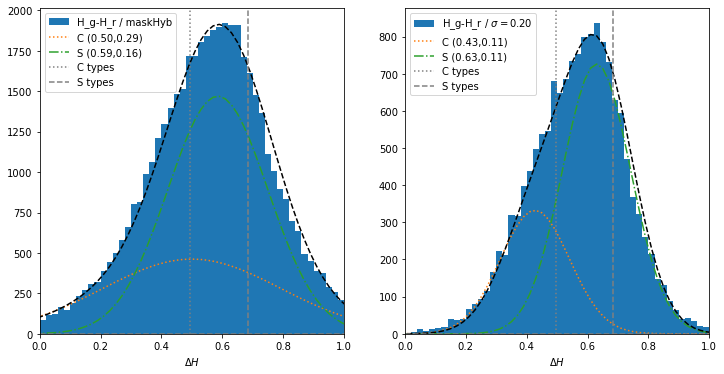

In [14]:
# Hybrid colors vs expectations
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-0.5,1.5]
b = 100

cond = maskG1G2hyb
dH = data.loc[cond,'HG1G2hyb_H_g'] - data.loc[cond,'HG1G2hyb_H_r']
bin_values, bin_boundaries, _ = ax[0].hist( dH, range=r, bins=b, label='H_g-H_r / maskHyb' )


# bin_values, bin_boundaries = np.histogram(dH, bins=b)
x = bin_boundaries[:-1] + 0.5*(bin_boundaries[1] - bin_boundaries[0])
popt, pcov = curve_fit(
    double_gauss, 
    x, 
    bin_values, 
    p0=[1000, color_C, 0.1, 1000, color_S, 0.1], 
    bounds=([0, 0, 0, 0.5, 0, 0], [1e5, 0.5, 1.5, 1e5, 1.0, 1.5])
)
ax[0].plot(x, gauss(x, *popt[:3]), label='C ({:.2f},{:.2f})'.format(popt[1],popt[2]), ls='dotted')
ax[0].plot(x, gauss(x, *popt[3:]), label='S ({:.2f},{:.2f})'.format(popt[4],popt[5]), ls='dashdot')
ax[0].plot(x, double_gauss(bin_boundaries[:-1], *popt), ls='--', color='black')

ax[0].axvline( color_C, color='gray', linestyle='dotted', label='C types')
ax[0].axvline( color_S, color='gray', linestyle='dashed', label='S types')


unc_H = 0.2
cond = maskG1G2hyb * \
       (data['HG1G2hyb_dH_g']<unc_H) * \
       (data['HG1G2hyb_dH_r']<unc_H)
dH = data.loc[cond,'HG1G2hyb_H_g'] - data.loc[cond,'HG1G2hyb_H_r']
bin_values, bin_boundaries, _ = ax[1].hist( dH, range=r, bins=b, label=f'H_g-H_r / $\sigma={unc_H:.2f}$' )


# bin_values, bin_boundaries = np.histogram(dH, bins=b)
x = bin_boundaries[:-1] + 0.5*(bin_boundaries[1] - bin_boundaries[0])
popt, pcov = curve_fit(
    double_gauss, 
    x, 
    bin_values, 
    p0=[1000, color_C, 0.1, 1000, color_S, 0.1], 
    bounds=([0, 0, 0, 0.5, 0, 0], [1e5, 0.5, 1.5, 1e5, 1.0, 1.5])
)
ax[1].plot(x, gauss(x, *popt[:3]), label='C ({:.2f},{:.2f})'.format(popt[1],popt[2]), ls='dotted')
ax[1].plot(x, gauss(x, *popt[3:]), label='S ({:.2f},{:.2f})'.format(popt[4],popt[5]), ls='dashdot')
ax[1].plot(x, double_gauss(bin_boundaries[:-1], *popt), ls='--', color='black')

ax[1].axvline( color_C, color='gray', linestyle='dotted', label='C types')
ax[1].axvline( color_S, color='gray', linestyle='dashed', label='S types')



for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.axhline(0.5, color='gray', linestyle='--')
    a.set_xlim(0,1)

fig.savefig(f'{data_fink}/gfx_models/deltaH_g_r.png', facecolor='white')

In [16]:
# Probability of C/S
bin_values, bin_boundaries, _ = ax[1].hist( dH, range=r, bins=b, label=f'H_g-H_r / $\sigma={unc_H:.2f}$' )
bin_boundaries = bin_boundaries[:-1] + (bin_boundaries[1]-bin_boundaries[0])/2

# Two-Gaussian model
gc = models.Gaussian1D(amplitude=300, mean=0.44, stddev=0.08)
gs = models.Gaussian1D(amplitude=700, mean=0.63, stddev=0.08)

init = gc + gs + models.Const1D(0.1)
fit_t = fitting.LevMarLSQFitter()
g = fit_t(init, bin_boundaries, bin_values)

# Compute probability
x1 = ( (data['HG1G2hyb_H_g'] - data['HG1G2hyb_H_r']) - (data['HG1G2hyb_dH_g'] - data['HG1G2hyb_dH_r']) ).to_numpy()
x2 = ( (data['HG1G2hyb_H_g'] - data['HG1G2hyb_H_r']) + (data['HG1G2hyb_dH_g'] - data['HG1G2hyb_dH_r']) ).to_numpy()

g0sum = g[0].amplitude*np.sqrt(2.0 * np.pi * g[0].stddev)
g1sum = g[1].amplitude*np.sqrt(2.0 * np.pi * g[1].stddev)

sqrt2 = np.sqrt(2.0)
pC = (g[0].amplitude.value*special.erf((x2 - g[0].mean.value) / (sqrt2 * g[0].stddev.value)) - 
          g[0].amplitude.value*special.erf((x1 - g[0].mean.value) / (sqrt2 * g[0].stddev.value)))
pS = (g[1].amplitude*special.erf((x2 - g[1].mean) / (sqrt2 * g[1].stddev)) - 
          g[1].amplitude*special.erf((x1 - g[1].mean) / (sqrt2 * g[1].stddev)))

# Add Class to DataFrame
data['pC'] = 0.0
data['pS'] = 0.0
data['complex'] = 'U'

cond_z = (pC + pS) > 0
data.loc[cond_z, 'pC'] = pC[cond_z] / (pC[cond_z] + pS[cond_z])
data.loc[cond_z, 'pS'] = pS[cond_z] / (pC[cond_z] + pS[cond_z])
rate = 0.2
cond = data['pS'] - data['pC'] > rate
data.loc[cond, 'complex'] = 'S'
data.loc[cond, 'pcomplex'] = data.loc[cond, 'pS']
cond = data['pC'] - data['pS'] > rate
data.loc[cond, 'complex'] = 'C'

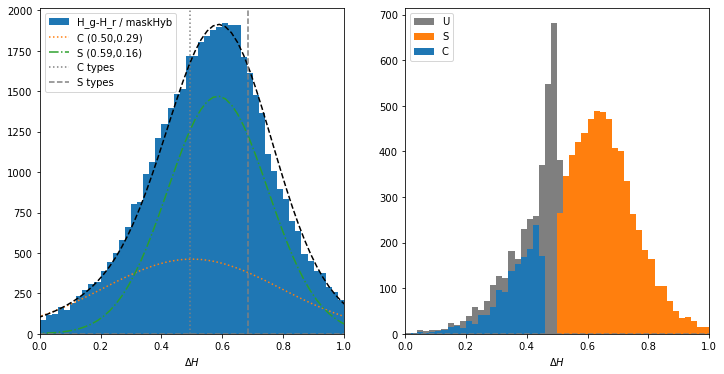

In [17]:
# Hybrid colors vs expectations
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-0.5,1.5]
b = 100

cond = maskG1G2hyb
dH = data.loc[cond,'HG1G2hyb_H_g'] - data.loc[cond,'HG1G2hyb_H_r']
bin_values, bin_boundaries, _ = ax[0].hist( dH, range=r, bins=b, label='H_g-H_r / maskHyb' )


# bin_values, bin_boundaries = np.histogram(dH, bins=b)
x = bin_boundaries[:-1] + 0.5*(bin_boundaries[1] - bin_boundaries[0])
popt, pcov = curve_fit(
    double_gauss, 
    x, 
    bin_values, 
    p0=[1000, color_C, 0.1, 1000, color_S, 0.1], 
    bounds=([0, 0, 0, 0.5, 0, 0], [1e5, 0.5, 1.5, 1e5, 1.0, 1.5])
)
ax[0].plot(x, gauss(x, *popt[:3]), label='C ({:.2f},{:.2f})'.format(popt[1],popt[2]), ls='dotted')
ax[0].plot(x, gauss(x, *popt[3:]), label='S ({:.2f},{:.2f})'.format(popt[4],popt[5]), ls='dashdot')
ax[0].plot(x, double_gauss(bin_boundaries[:-1], *popt), ls='--', color='black')

ax[0].axvline( color_C, color='gray', linestyle='dotted', label='C types')
ax[0].axvline( color_S, color='gray', linestyle='dashed', label='S types')


unc_H = 0.2
cond = maskG1G2hyb * \
       (data['HG1G2hyb_dH_g']<unc_H) * \
       (data['HG1G2hyb_dH_r']<unc_H)

cond = (data['complex']=='U') & maskG1G2hyb & (data['HG1G2hyb_dH_g']<unc_H) & (data['HG1G2hyb_dH_r']<unc_H)
dH = data.loc[cond,'HG1G2hyb_H_g'] - data.loc[cond,'HG1G2hyb_H_r']
bin_values, bin_boundaries, _ = ax[1].hist( dH, range=r, bins=b, label=f'U', color=plt.cm.tab10(7) )

cond = (data['complex']=='S') & maskG1G2hyb & (data['HG1G2hyb_dH_g']<unc_H) & (data['HG1G2hyb_dH_r']<unc_H)
dH = data.loc[cond,'HG1G2hyb_H_g'] - data.loc[cond,'HG1G2hyb_H_r']
bin_values, bin_boundaries, _ = ax[1].hist( dH, range=r, bins=b, label=f'S', color=plt.cm.tab10(1) )

cond = (data['complex']=='C') & maskG1G2hyb & (data['HG1G2hyb_dH_g']<unc_H) & (data['HG1G2hyb_dH_r']<unc_H)
dH = data.loc[cond,'HG1G2hyb_H_g'] - data.loc[cond,'HG1G2hyb_H_r']
bin_values, bin_boundaries, _ = ax[1].hist( dH, range=r, bins=b, label=f'C', color=plt.cm.tab10(0) )


# bin_values, bin_boundaries = np.histogram(dH, bins=b)
# x = bin_boundaries[:-1] + 0.5*(bin_boundaries[1] - bin_boundaries[0])
# popt, pcov = curve_fit(
#     double_gauss, 
#     x, 
#     bin_values, 
#     p0=[1000, color_C, 0.1, 1000, color_S, 0.1], 
#     bounds=([0, 0, 0, 0.5, 0, 0], [1e5, 0.5, 1.5, 1e5, 1.0, 1.5])
# )
# ax[1].plot(x, gauss(x, *popt[:3]), label='C ({:.2f},{:.2f})'.format(popt[1],popt[2]), ls='dotted')
# ax[1].plot(x, gauss(x, *popt[3:]), label='S ({:.2f},{:.2f})'.format(popt[4],popt[5]), ls='dashdot')
# ax[1].plot(x, double_gauss(bin_boundaries[:-1], *popt), ls='--', color='black')

# ax[1].axvline( color_C, color='gray', linestyle='dotted', label='C types')
# ax[1].axvline( color_S, color='gray', linestyle='dashed', label='S types')



for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.axhline(0.5, color='gray', linestyle='--')
    a.set_xlim(0,1)

fig.savefig(f'{data_fink}/gfx_models/deltaH_g_r.png', facecolor='white')

Text(0.5, 0, 'Eccentricity')

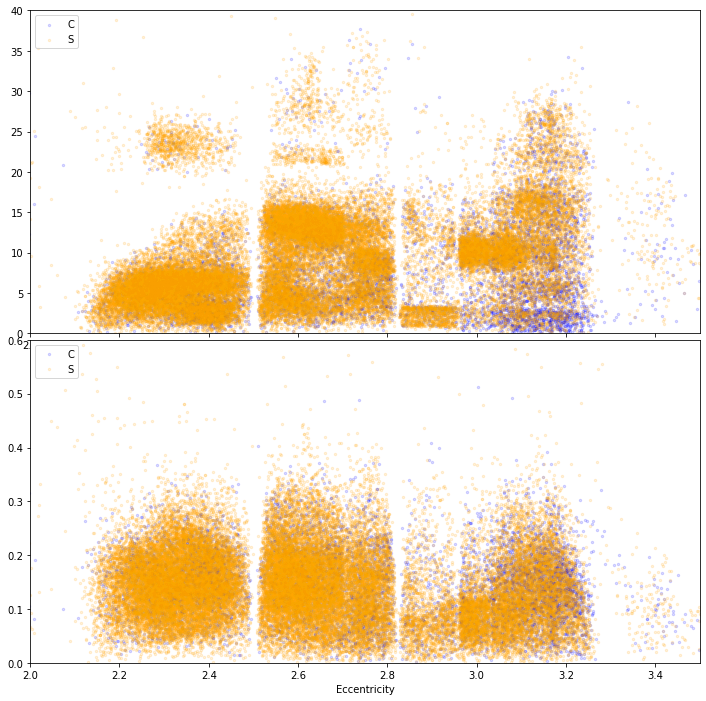

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(12,12), gridspec_kw={'hspace':0.02})

s = 6 

C = data['complex'] == 'C'
S = data['complex'] == 'S'

# a i
ax[0].scatter( data.loc[C,'orbital_elements.semi_major_axis.value'], 
               data.loc[C,'orbital_elements.inclination.value'], color='blue', label='C', s=s, alpha=0.15)
ax[0].scatter( data.loc[S,'orbital_elements.semi_major_axis.value'], 
               data.loc[S,'orbital_elements.inclination.value'], color='orange', label='S', s=s, alpha=0.15)

# a e
ax[1].scatter( data.loc[C,'orbital_elements.semi_major_axis.value'], 
               data.loc[C,'orbital_elements.eccentricity.value'], color='blue', label='C', s=s, alpha=0.15)
ax[1].scatter( data.loc[S,'orbital_elements.semi_major_axis.value'], 
               data.loc[S,'orbital_elements.eccentricity.value'], color='orange', label='S', s=s, alpha=0.15)

for a in ax:
    a.set_xlim(2,3.5)
    a.legend(loc='upper left')

ax[0].set_ylim(0,40)
ax[1].set_ylim(0,0.6)
ax[0].set_xlabel('Semi-major axis / au')
ax[0].set_xlabel('Inclination / deg')
ax[1].set_xlabel('Eccentricity')

# G1G2 distribution

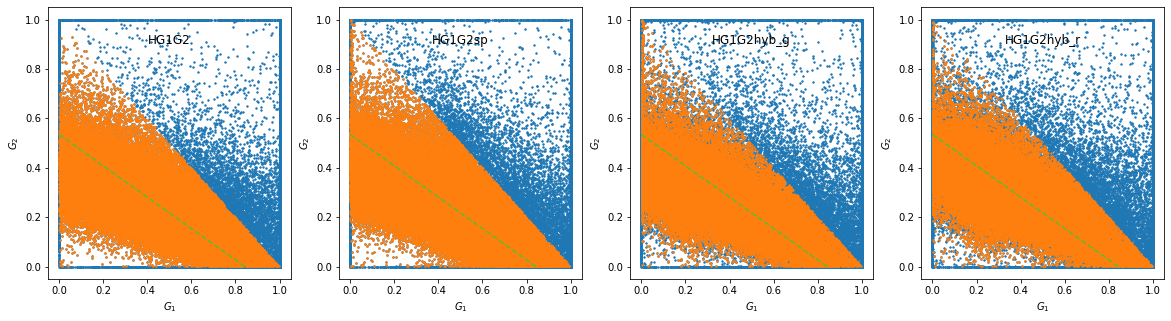

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))

r = [-2,2]
b = 100


ax[0].scatter( data.HG1G2_G1, data.HG1G2_G2, s=2 )
ax[0].scatter( data.loc[maskG1G2,'HG1G2_G1'], data.loc[maskG1G2,'HG1G2_G2'], s=2 )
ax[0].text( 0.5, 0.9, 'HG1G2', ha='center', fontsize='large') 

ax[1].scatter( data.HG1G2sp_G1, data.HG1G2sp_G2, s=2 )
ax[1].scatter( data.loc[maskG1G2sp,'HG1G2sp_G1'], data.loc[maskG1G2sp,'HG1G2sp_G2'], s=2 )
ax[1].text( 0.5, 0.9, 'HG1G2sp', ha='center', fontsize='large') 

ax[2].scatter( data['HG1G2hyb_G1_g'], data['HG1G2hyb_G2_g'], s=2 )
ax[2].scatter( data.loc[maskG1G2hyb,'HG1G2hyb_G1_g'], data.loc[maskG1G2hyb,'HG1G2hyb_G2_g'], s=2 )
ax[2].text( 0.5, 0.9, 'HG1G2hyb_g', ha='center', fontsize='large') 

ax[3].scatter( data['HG1G2hyb_G1_r'], data['HG1G2hyb_G2_r'], s=2 )
ax[3].scatter( data.loc[maskG1G2hyb,'HG1G2hyb_G1_r'], data.loc[maskG1G2hyb,'HG1G2hyb_G2_r'], s=2 )
ax[3].text( 0.5, 0.9, 'HG1G2hyb_r', ha='center', fontsize='large') 


for a in ax:
    a.set_xlabel('$G_1$')
    a.set_ylabel('$G_2$')
    
    xx = np.linspace(0,1,num=5)
    # a.plot( xx, 1-xx, color='k' )
    
    G1, G2 = G12_to_G1G2(xx)
    a.plot(G1, G2, linestyle="--", color="limegreen", alpha=0.8)

fig.savefig(f'{data_fink}/gfx_models/G1G2_models.png', facecolor='white')

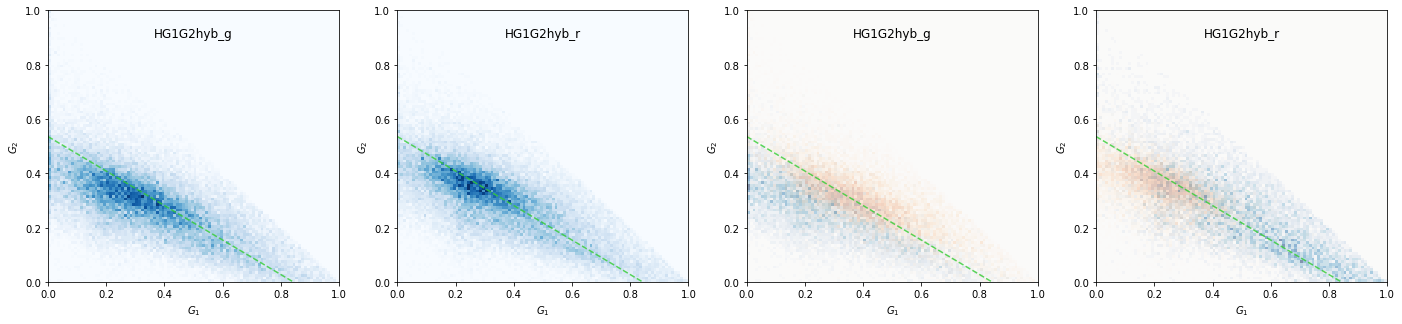

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(24,5))

r = [0,1]
b = 100

ax[0].hist2d( data.loc[maskG1G2hyb,'HG1G2hyb_G1_g'], data.loc[maskG1G2hyb,'HG1G2hyb_G2_g'], 
              range=[r,r], bins=100, cmap='Blues' )
ax[0].text( 0.5, 0.9, 'HG1G2hyb_g', ha='center', fontsize='large') 

ax[1].hist2d( data.loc[maskG1G2hyb,'HG1G2hyb_G1_r'], data.loc[maskG1G2hyb,'HG1G2hyb_G2_r'], 
              range=[r,r], bins=100, cmap='Blues' )
ax[1].text( 0.5, 0.9, 'HG1G2hyb_r', ha='center', fontsize='large') 


cond = maskG1G2hyb * \
       ( (data['HG1G2hyb_H_g'] - data['HG1G2hyb_H_r']) > 0.6 )
ax[2].hist2d( data.loc[cond,'HG1G2hyb_G1_g'], data.loc[cond,'HG1G2hyb_G2_g'], 
              range=[r,r], bins=100, cmap='Oranges', alpha=0.5, label='S?' )
cond = maskG1G2hyb * \
       ( (data['HG1G2hyb_H_g'] - data['HG1G2hyb_H_r']) < 0.4 )
ax[2].hist2d( data.loc[cond,'HG1G2hyb_G1_g'], data.loc[cond,'HG1G2hyb_G2_g'], 
              range=[r,r], bins=100, cmap='Blues', alpha=0.5, label='C?' )

ax[2].text( 0.5, 0.9, 'HG1G2hyb_g', ha='center', fontsize='large') 



cond = maskG1G2hyb * \
       ( (data['HG1G2hyb_H_g'] - data['HG1G2hyb_H_r']) > 0.6 )
ax[3].hist2d( data.loc[cond,'HG1G2hyb_G1_r'], data.loc[cond,'HG1G2hyb_G2_r'], 
              range=[r,r], bins=100, cmap='Oranges', alpha=0.5, label='S?' )
cond = maskG1G2hyb * \
       ( (data['HG1G2hyb_H_g'] - data['HG1G2hyb_H_r']) < 0.4 )
ax[3].hist2d( data.loc[cond,'HG1G2hyb_G1_r'], data.loc[cond,'HG1G2hyb_G2_r'], 
              range=[r,r], bins=100, cmap='Blues', alpha=0.5, label='C?' )

ax[3].text( 0.5, 0.9, 'HG1G2hyb_r', ha='center', fontsize='large') 


for a in ax:
    a.set_xlabel('$G_1$')
    a.set_ylabel('$G_2$')
    
    xx = np.linspace(0,1,num=5)
    G1, G2 = G12_to_G1G2(xx)
    a.plot(G1, G2, linestyle="--", color="limegreen", alpha=0.8)

fig.savefig(f'{data_fink}/gfx_models/G1G2_hist2d.png', facecolor='white')

- overall distribution of G1G2 looks good
- 2 last plots: C=blue S=orange
- in g the split S/C is weird in G1G2
- in r, the split S/C is as expected

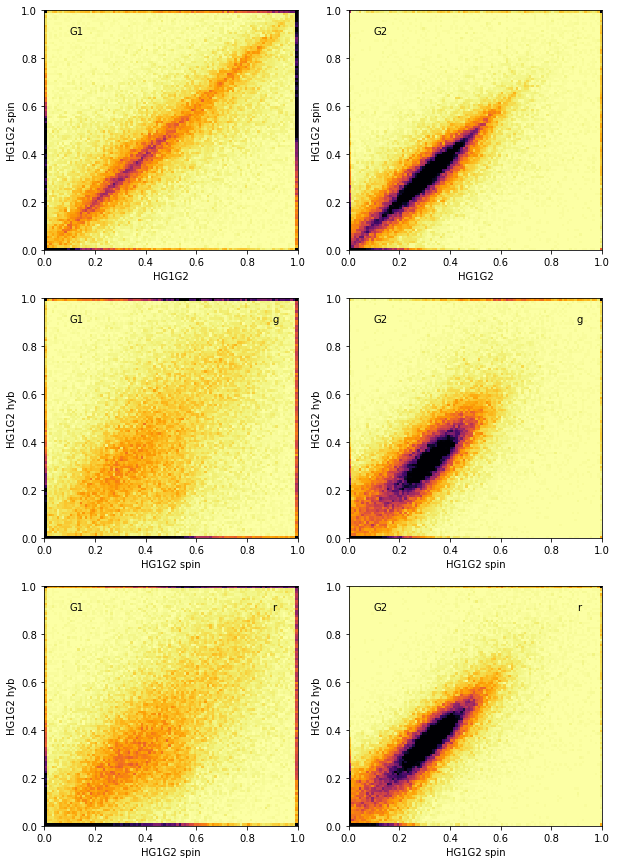

In [21]:
# Overall comparison of G1 G2
fig, axs = plt.subplots(3, 2, figsize=(10,15))

ax = axs.ravel() 
r = [0,1]
b = 100
vmax = 10

ax[0].hist2d( data.HG1G2_G1, data.HG1G2sp_G1, density=True, vmin=0, vmax=vmax, range=[r,r], bins=b, cmap='inferno_r' )
ax[1].hist2d( data.HG1G2_G2, data.HG1G2sp_G2, density=True, vmin=0, vmax=vmax, range=[r,r], bins=b, cmap='inferno_r' )

ax[2].hist2d( data.HG1G2sp_G1, data.HG1G2hyb_G1_g, density=True, vmin=0, vmax=vmax, range=[r,r], bins=b, cmap='inferno_r' )
ax[3].hist2d( data.HG1G2sp_G2, data.HG1G2hyb_G2_g, density=True, vmin=0, vmax=vmax, range=[r,r], bins=b, cmap='inferno_r' )

ax[4].hist2d( data.HG1G2sp_G1, data.HG1G2hyb_G1_r, density=True, vmin=0, vmax=vmax, range=[r,r], bins=b, cmap='inferno_r' )
ax[5].hist2d( data.HG1G2sp_G2, data.HG1G2hyb_G2_r, density=True, vmin=0, vmax=vmax, range=[r,r], bins=b, cmap='inferno_r' )

for a in ax[[0,2,4]]:
    a.text(0.1, 0.9, 'G1')
for a in ax[[1,3,5]]:
    a.text(0.1, 0.9, 'G2')

for a in ax[[0,1]]:
    a.set_xlabel('HG1G2')
    a.set_ylabel('HG1G2 spin')
for a in ax[[2,3]]:
    a.set_xlabel('HG1G2 spin')
    a.set_ylabel('HG1G2 hyb')
    a.text(0.9, 0.9, 'g')
for a in ax[[4,5]]:
    a.set_xlabel('HG1G2 spin')
    a.set_ylabel('HG1G2 hyb')
    a.text(0.9, 0.9, 'r')



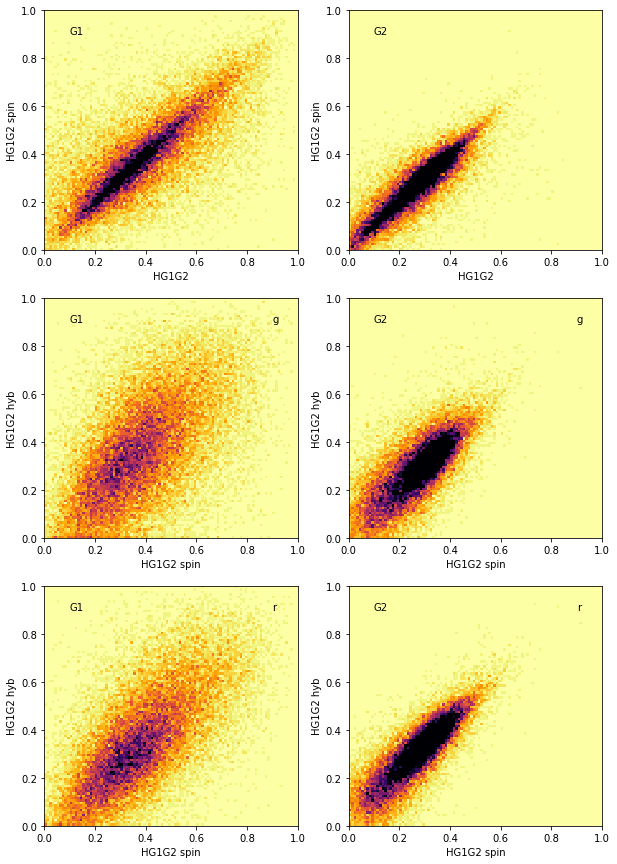

In [22]:
# Comparison of G1 G2 for the set of physical values
fig, axs = plt.subplots(3, 2, figsize=(10,15))

ax = axs.ravel() 
r = [0,1]
b = 100
vmax = 10

cond = mask

ax[0].hist2d( data.loc[cond,'HG1G2_G1'], data.loc[cond,'HG1G2sp_G1'], density=True, vmin=0, vmax=vmax, range=[r,r], bins=b, cmap='inferno_r' )
ax[1].hist2d( data.loc[cond,'HG1G2_G2'], data.loc[cond,'HG1G2sp_G2'], density=True, vmin=0, vmax=vmax, range=[r,r], bins=b, cmap='inferno_r' )

ax[2].hist2d( data.loc[cond,'HG1G2sp_G1'], data.loc[cond,'HG1G2hyb_G1_g'], density=True, vmin=0, vmax=vmax, range=[r,r], bins=b, cmap='inferno_r' )
ax[3].hist2d( data.loc[cond,'HG1G2sp_G2'], data.loc[cond,'HG1G2hyb_G2_g'], density=True, vmin=0, vmax=vmax, range=[r,r], bins=b, cmap='inferno_r' )

ax[4].hist2d( data.loc[cond,'HG1G2sp_G1'], data.loc[cond,'HG1G2hyb_G1_r'], density=True, vmin=0, vmax=vmax, range=[r,r], bins=b, cmap='inferno_r' )
ax[5].hist2d( data.loc[cond,'HG1G2sp_G2'], data.loc[cond,'HG1G2hyb_G2_r'], density=True, vmin=0, vmax=vmax, range=[r,r], bins=b, cmap='inferno_r' )

for a in ax[[0,2,4]]:
    a.text(0.1, 0.9, 'G1')
for a in ax[[1,3,5]]:
    a.text(0.1, 0.9, 'G2')

for a in ax[[0,1]]:
    a.set_xlabel('HG1G2')
    a.set_ylabel('HG1G2 spin')
for a in ax[[2,3]]:
    a.set_xlabel('HG1G2 spin')
    a.set_ylabel('HG1G2 hyb')
    a.text(0.9, 0.9, 'g')
for a in ax[[4,5]]:
    a.set_xlabel('HG1G2 spin')
    a.set_ylabel('HG1G2 hyb')
    a.text(0.9, 0.9, 'r')



# Chi-square

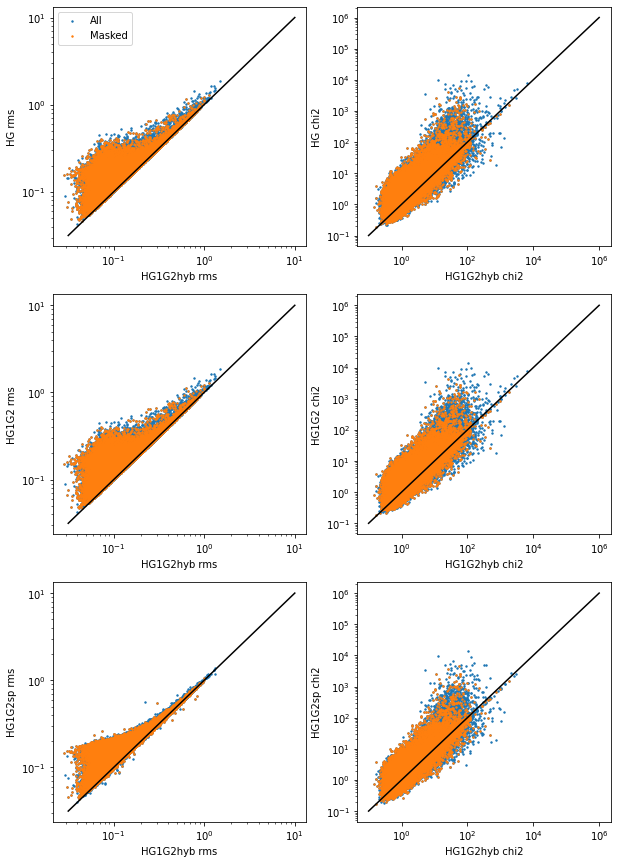

In [23]:
fig, axs = plt.subplots(3, 2, figsize=(10,15))

ref = 'HG1G2hyb'

cond = mask # All ok
cond = maskG1G2hyb # Hybrid ok


for km, model in enumerate(['HG','HG1G2','HG1G2sp']):
    
    # print(km, model)
    axs[km,0].scatter( data.loc[:,f'{ref}_rms'], data.loc[:,f'{model}_rms'], s=2, label='All' )
    axs[km,0].scatter( data.loc[cond,f'{ref}_rms'], data.loc[cond,f'{model}_rms'], s=2, label='Masked' )
    axs[km,0].set_xlabel( f'{ref} rms' )
    axs[km,0].set_ylabel( f'{model} rms' )        
        
    axs[km,1].scatter( data.loc[:,f'{ref}_chi2red'], data.loc[:,f'{model}_chi2red'], s=2 )
    axs[km,1].scatter( data.loc[cond,f'{ref}_chi2red'], data.loc[cond,f'{model}_chi2red'], s=2 )
    axs[km,1].set_xlabel( f'{ref} chi2' )
    axs[km,1].set_ylabel( f'{model} chi2' )

x_rms = np.logspace(-1.5, 1, num=100 )
x_chi = np.logspace(-1, 6, num=100 )

for a in axs[:,0]:
    a.plot(x_rms, x_rms, color='black')
    
for a in axs[:,1]:
    a.plot(x_chi, x_chi, color='black')

for a in axs.ravel():
    a.set_xscale('log')
    a.set_yscale('log')
    
axs[0,0].legend(loc='upper left')

fig.savefig(f'{data_fink}/gfx_models/rms_models.png', facecolor='white')

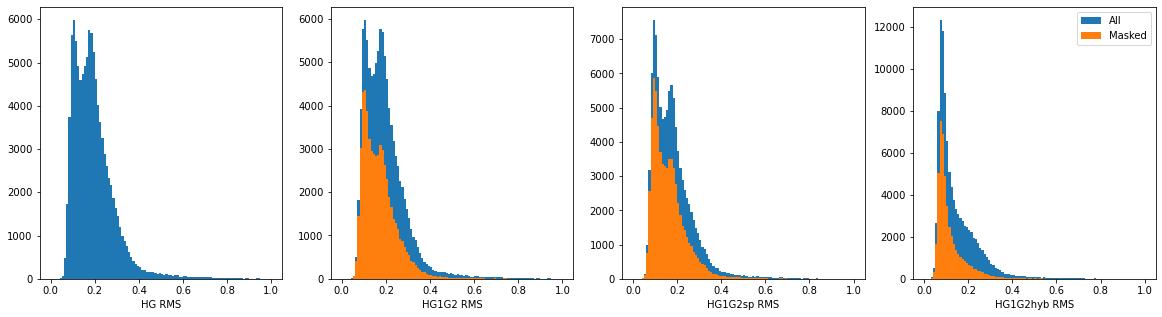

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

r = [0,1]
b = 100


for km, model in enumerate(['HG','HG1G2','HG1G2sp','HG1G2hyb']):
    
    ax[km].hist( data.loc[:,f'{model}_rms'], range=r, bins=b, label='All')

    if model=='HG1G2':
        ax[km].hist( data.loc[maskG1G2,f'{model}_rms'], range=r, bins=b, label='Masked')
    elif model=='HG1G2sp':
        ax[km].hist( data.loc[maskG1G2sp,f'{model}_rms'], range=r, bins=b, label='Masked')
    elif model=='HG1G2hyb':
        ax[km].hist( data.loc[maskG1G2hyb,f'{model}_rms'], range=r, bins=b, label='Masked')

    ax[km].set_xlabel(f'{model} RMS')

    
ax[3].legend(loc='upper right')
fig.savefig(f'{data_fink}/gfx_models/rms_histo.png', facecolor='white')

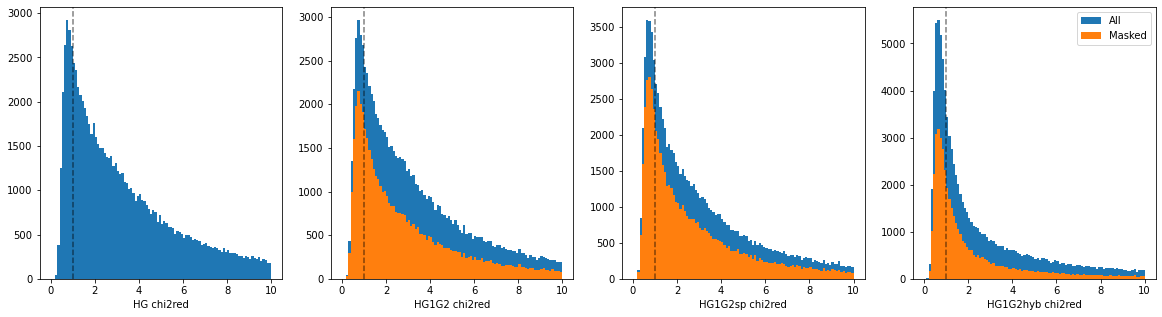

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

r = [0,10]
b = 100


for km, model in enumerate(['HG','HG1G2','HG1G2sp','HG1G2hyb']):
    
    ax[km].hist( data.loc[:,f'{model}_chi2red'], range=r, bins=b, label='All')

    if model=='HG1G2':
        ax[km].hist( data.loc[maskG1G2,f'{model}_chi2red'], range=r, bins=b, label='Masked')
    elif model=='HG1G2sp':
        ax[km].hist( data.loc[maskG1G2sp,f'{model}_chi2red'], range=r, bins=b, label='Masked')
    elif model=='HG1G2hyb':
        ax[km].hist( data.loc[maskG1G2hyb,f'{model}_chi2red'], range=r, bins=b, label='Masked')

    ax[km].axvline(1,linestyle='dashed', color='black', alpha=0.5 )
    ax[km].set_xlabel(f'{model} chi2red')

    
ax[3].legend(loc='upper right')
fig.savefig(f'{data_fink}/gfx_models/chi2_histo.png', facecolor='white')

# Spins

In [26]:
data.columns

Index(['ssnamenr', 'number', 'name', 'minphase', 'maxphase', 'n_days', 'n_obs',
       'HG_H', 'HG_dH', 'HG_G',
       ...
       'spins.4.obliquity', 'spins.4.RA0.value', 'spins.4.DEC0.value',
       'spins.4.long.value', 'spins.4.lat.value', 'spins.4.technique', 'pC',
       'pS', 'complex', 'pcomplex'],
      dtype='object', length=118)

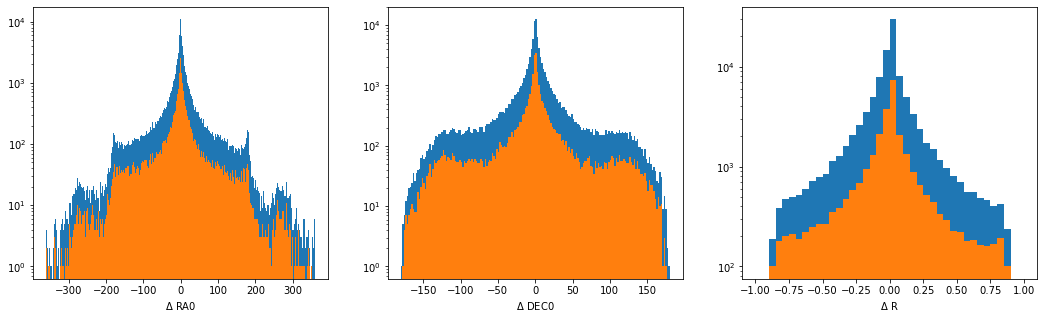

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

r = [-360,360]
b = 360
ax[0].hist( data.loc[:,'HG1G2sp_RA0']-data.loc[:,'HG1G2hyb_RA0'], range=r, bins=b, label='All')
ax[0].hist( data.loc[mask,'HG1G2sp_RA0']-data.loc[mask,'HG1G2hyb_RA0'], range=r, bins=b, label='Masked')

r = [-180,180]
b = 180
ax[1].hist( data.loc[:,'HG1G2sp_DEC0']-data.loc[:,'HG1G2hyb_DEC0'], range=r, bins=b, label='All')
ax[1].hist( data.loc[mask,'HG1G2sp_DEC0']-data.loc[mask,'HG1G2hyb_DEC0'], range=r, bins=b, label='Masked')

r = [-1,1]
b = 40
ax[2].hist( data.loc[:,'HG1G2sp_R']-data.loc[:,'HG1G2hyb_R'], range=r, bins=b, label='All')
ax[2].hist( data.loc[mask,'HG1G2sp_R']-data.loc[mask,'HG1G2hyb_R'], range=r, bins=b, label='Masked')


ax[0].set_xlabel(f'$\Delta$ RA0')
ax[1].set_xlabel(f'$\Delta$ DEC0')
ax[2].set_xlabel(f'$\Delta$ R')

for a in ax:
    a.set_yscale('log')
# ax[3].legend(loc='upper right')

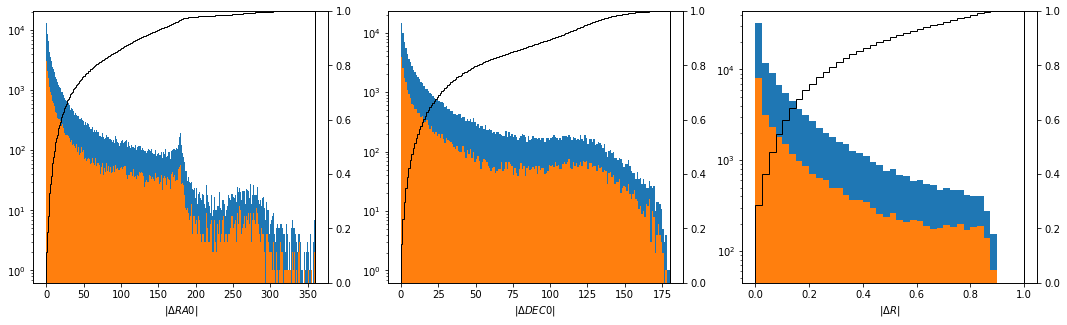

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

r = [0,360]
b = 360
ax[0].hist( np.abs(data.loc[:,'HG1G2sp_RA0']-data.loc[:,'HG1G2hyb_RA0']), range=r, bins=b, label='All')
ax[0].hist( np.abs(data.loc[mask,'HG1G2sp_RA0']-data.loc[mask,'HG1G2hyb_RA0']), range=r, bins=b, label='Masked')
ax0 = ax[0].twinx()
ax0.hist( np.abs(data.loc[mask,'HG1G2sp_RA0']-data.loc[mask,'HG1G2hyb_RA0']), range=r, bins=b, density=True, cumulative=True, histtype='step', color='black')

r = [0,180]
b = 180
ax[1].hist( np.abs(data.loc[:,'HG1G2sp_DEC0']-data.loc[:,'HG1G2hyb_DEC0']), range=r, bins=b, label='All')
ax[1].hist( np.abs(data.loc[mask,'HG1G2sp_DEC0']-data.loc[mask,'HG1G2hyb_DEC0']), range=r, bins=b, label='Masked')
ax1 = ax[1].twinx()
ax1.hist( np.abs(data.loc[mask,'HG1G2sp_DEC0']-data.loc[mask,'HG1G2hyb_DEC0']), range=r, bins=b, density=True, cumulative=True, histtype='step', color='black')

r = [0,1]
b = 40
ax[2].hist( np.abs(data.loc[:,'HG1G2sp_R']-data.loc[:,'HG1G2hyb_R']), range=r, bins=b, label='All')
ax[2].hist( np.abs(data.loc[mask,'HG1G2sp_R']-data.loc[mask,'HG1G2hyb_R']), range=r, bins=b, label='Masked')
ax2 = ax[2].twinx()
ax2.hist( np.abs(data.loc[mask,'HG1G2sp_R']-data.loc[mask,'HG1G2hyb_R']), range=r, bins=b, density=True, cumulative=True, histtype='step', color='black')


ax[0].set_xlabel(f'$| \Delta RA0 |$')
ax[1].set_xlabel(f'$| \Delta DEC0 |$')
ax[2].set_xlabel(f'$| \Delta R |$')

for a in ax:
    a.set_yscale('log')
for a in [ax0,ax1,ax2]:
    a.set_ylim(0,1)
    
    
# ax[3].legend(loc='upper right')

# Best and worst cases

In [29]:
data['delta_rms'] = data['HG1G2hyb_rms'] - data['HG1G2_rms']
data[mask].sort_values(by='delta_rms').head(20)

,ssnamenr,number,name,minphase,maxphase,n_days,n_obs,HG_H,HG_dH,HG_G,...,spins.4.RA0.value,spins.4.DEC0.value,spins.4.long.value,spins.4.lat.value,spins.4.technique,pC,pS,complex,pcomplex,delta_rms
99481,29941,29941,1999 JB76,0.346470,20.061215,1075.610313,133,14.263897,0.097532,3.274027e-01,...,NaN,NaN,NaN,NaN,None,0.144164,0.855836,S,0.855836,-0.299354
78714,45200,45200,1999 XS170,1.513213,26.672616,1046.943958,54,15.353032,0.154107,3.163797e-01,...,NaN,NaN,NaN,NaN,None,0.035076,0.964924,S,0.964924,-0.286133
22305,187769,187769,1998 RX29,1.570487,23.161848,672.689688,58,15.429918,0.143356,1.671396e-01,...,NaN,NaN,NaN,NaN,None,0.000000,0.000000,U,NaN,-0.275616
50828,22127,22127,2000 SZ226,1.571903,22.101994,1019.657315,109,14.578253,0.110363,1.776835e-01,...,NaN,NaN,NaN,NaN,None,0.101991,0.898009,S,0.898009,-0.262509
37329,3646,3646,Aduatiques,0.431563,24.076557,1070.649653,142,13.448200,0.070094,1.214005e-01,...,NaN,NaN,NaN,NaN,None,0.000000,0.000000,U,NaN,-0.258789
54051,223,223,Rosa,1.189458,21.367646,930.027847,173,9.917361,0.092544,3.633714e-03,...,NaN,NaN,NaN,NaN,None,0.178403,0.821597,S,0.821597,-0.252485
81967,95611,95611,2002 FS34,1.367394,19.254822,957.959907,54,15.131219,0.101620,2.500903e-15,...,NaN,NaN,NaN,NaN,None,0.192838,0.807162,S,0.807162,-0.250212
34729,61686,61686,2000 QV126,0.408857,21.038301,926.152986,55,15.483210,0.146628,2.439380e-01,...,NaN,NaN,NaN,NaN,None,0.905156,0.094844,C,NaN,-0.248570
95838,23610,23610,1996 AW7,0.356646,21.129895,977.849734,57,15.030464,0.090324,1.554756e-01,...,NaN,NaN,NaN,NaN,None,0.000000,0.000000,U,NaN,-0.244939
52254,19587,19587,Keremane,1.271689,20.863883,1180.347651,172,14.081903,0.079972,2.327099e-01,...,NaN,NaN,NaN,NaN,None,0.000000,0.000000,U,NaN,-0.242609
